In [1]:
import math
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root='./data', 
                          train=True,
                          download=True,
                          transform=transform)

In [7]:
print(train_ds.data.shape)
print(train_ds.targets.shape)
print(train_ds.classes)
print(train_ds.data[0])
print(train_ds.targets[0])
print(train_ds.data[0].max())
print(train_ds.data[0].min())
print(train_ds.data[0].float().mean())
print(train_ds.data[0].float().std())

torch.Size([60000, 28, 28])
torch.Size([60000])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   

In [9]:
# Build dataloader
dl = DataLoader(dataset=train_ds,
                shuffle=True,
                batch_size=64)

In [11]:
# Examine a sample batch from the dataloader
image_batch = next(iter(dl))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)

2 <class 'list'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


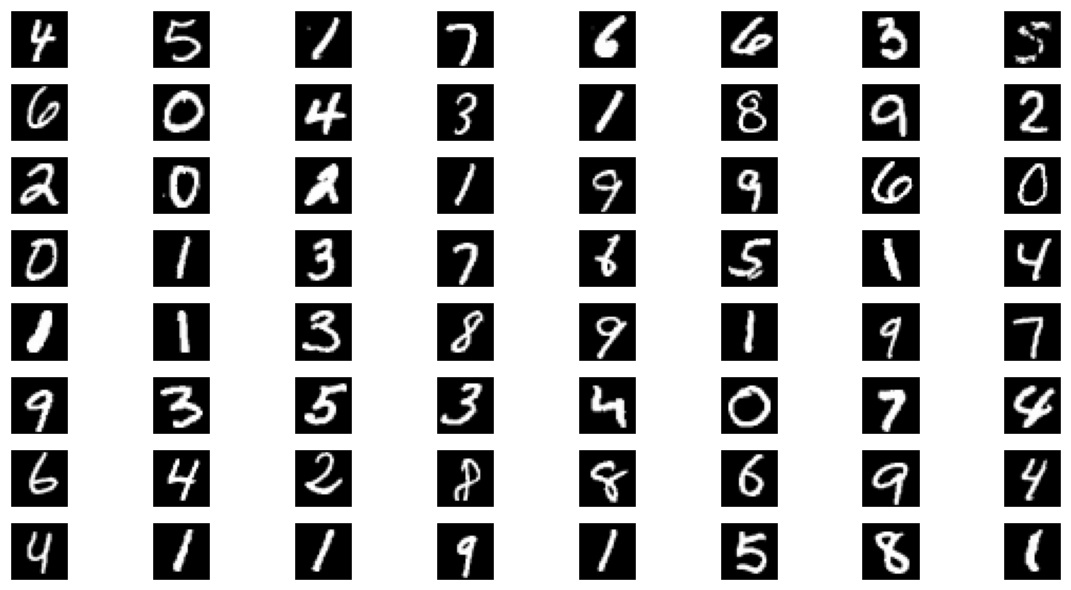

In [65]:
## Visualise a sample batch

def display_images(images, n_cols=4, figsize=(12, 6)):
    """
    Utility function to display a collection of images in a grid
    
    Parameters
    ----------
    images: Tensor
            tensor of shape (batch_size, channel, height, width)
            containing images to be displayed
    n_cols: int
            number of columns in the grid
            
    Returns
    -------
    None
    """
    plt.style.use('ggplot')
    n_images = len(images)
    n_rows = math.ceil(n_images / n_cols)
    plt.figure(figsize=figsize)
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx+1)
        image = images[idx]
        # make dims H x W x C
        image = image.permute(1, 2, 0)
        cmap = 'gray' if image.shape[2] == 1 else plt.cm.viridis
        ax.imshow(image, cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])        
    plt.tight_layout()
    plt.show()

display_images(images=image_batch[0], n_cols=8)

In [15]:
class Discriminator(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Discriminator will down-sample the input producing a binary output
        self.fc1 = nn.Linear(in_features=in_features, out_features=128)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc4 = nn.Linear(in_features=32, out_features=out_features)
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # Rehape passed image batch
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        # Feed forward
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.dropout(x)                        
        x = self.fc3(x)
        x = self.leaky_relu3(x)        
        x = self.dropout(x)
        logit_out = self.fc4(x)
        
        return logit_out

In [17]:
class Generator(nn.Module):
    def __init__(self, in_features, out_features):
        super(Generator, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Generator will up-sample the input producing input of size
        # suitable for feeding into discriminator
        self.fc1 = nn.Linear(in_features=in_features, out_features=32)
        self.relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=32, out_features=64)
        self.relu2 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc3 = nn.Linear(in_features=64, out_features=128)
        self.relu3 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc4 = nn.Linear(in_features=128, out_features=out_features)
        self.dropout = nn.Dropout(0.3)
        self.tanh = nn.Tanh()
        
        
    def forward(self, x):
        # Feed forward
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)        
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)        
        x = self.dropout(x)
        x = self.fc4(x)
        tanh_out = self.tanh(x)
        
        return tanh_out

In [19]:
def real_loss(predicted_outputs, loss_fn, device):
    """
    Function for calculating loss when samples are drawn from real dataset
    
    Parameters
    ----------
    predicted_outputs: Tensor
                       predicted logits
            
    Returns
    -------
    real_loss: int
    """
    batch_size = predicted_outputs.shape[0]
    # Targets are set to 1 here because we expect prediction to be 
    # 1 (or near 1) since samples are drawn from real dataset
    targets = torch.ones(batch_size).to(device)
    real_loss = loss_fn(predicted_outputs.squeeze(), targets)
    
    return real_loss


def fake_loss(predicted_outputs, loss_fn, device):
    """
    Function for calculating loss when samples are generated fake samples
    
    Parameters
    ----------
    predicted_outputs: Tensor
                       predicted logits
            
    Returns
    -------
    fake_loss: int
    """
    batch_size = predicted_outputs.shape[0]
    # Targets are set to 0 here because we expect prediction to be 
    # 0 (or near 0) since samples are generated fake samples
    targets = torch.zeros(batch_size).to(device)
    fake_loss = loss_fn(predicted_outputs.squeeze(), targets)
    
    return fake_loss 

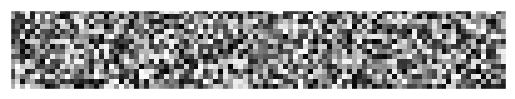

In [21]:
#Sample generation of latent vector
z_size = 100
z = np.random.uniform(-1, 1, size=(16, z_size))
plt.imshow(z, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [23]:
# Training loop function

def train_minst_gan(d, g, d_optim, g_optim, loss_fn, dl, n_epochs, device, verbose=False):
    print(f'Training on [{device}]...')
    
    # Generate a batch (say 16) of latent image vector (z) of fixed size 
    # (say 100 pix) to be as input to the Generator after each epoch of 
    # training to generate a fake image. We'll visualise these fake images
    # to get a sense how generator improves as training progresses
    z_size = 100
    fixed_z = np.random.uniform(-1, 1, size=(16, z_size))
    fixed_z = torch.from_numpy(fixed_z).float().to(device)          
    fixed_samples = []
    d_losses = []
    g_losses = []
    
    
    # Move discriminator and generator to available device
    d = d.to(device)
    g = g.to(device)
    
    for epoch in range(n_epochs):
        print(f'Epoch [{epoch+1}/{n_epochs}]:')
        # Switch the training mode on
        d.train()
        g.train()
        d_running_batch_loss = 0
        g_running_batch_loss = 0
        for curr_batch, (real_images, _) in enumerate(dl):
            # Move input batch to available device
            real_images = real_images.to(device)
            
            ## ----------------------------------------------------------------
            ## Train discriminator using real and then fake MNIST images,  
            ## then compute the total-loss and back-propogate the total-loss
            ## ----------------------------------------------------------------
            
            # Reset gradients
            d_optim.zero_grad()
            
            # Real MNIST images
            # Convert real_images value range of 0 to 1 to -1 to 1
            # this is required because latter discriminator would be required 
            # to consume generator's 'tanh' output which is of range -1 to 1
            real_images = (real_images * 2) - 1  
            d_real_logits_out = d(real_images)
            d_real_loss = real_loss(d_real_logits_out, loss_fn, device)
            #d_real_loss = real_loss(d_real_logits_out, smooth=True)
            
            # Fake images
            with torch.no_grad():
                # Generate a batch of random latent vectors 
                z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
                z = torch.from_numpy(z).float().to(device)
                # Generate batch of fake images
                fake_images = g(z) 
            # feed fake-images to discriminator and compute the 
            # fake_loss (i.e. target label = 0)
            d_fake_logits_out = d(fake_images)
            d_fake_loss = fake_loss(d_fake_logits_out, loss_fn, device)
            #d_fake_loss = fake_loss(d_fake_logits_out)
            # Compute total discriminator loss
            d_loss = d_real_loss + d_fake_loss
            # Backpropogate through discriminator
            d_loss.backward()
            d_optim.step()
            # Save discriminator batch loss
            d_running_batch_loss += d_loss
            
            ## ----------------------------------------------------------------
            ## Train generator, compute the generator loss which is a measure
            ## of how successful the generator is in tricking the discriminator 
            ## and finally back-propogate generator loss
            ## ----------------------------------------------------------------

            # Reset gradients
            g_optim.zero_grad()
            
            # Generate a batch of random latent vectors
            #z = torch.rand(size=(dl.batch_size, z_size)).to(device)
            z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
            z = torch.from_numpy(z).float().to(device)       
            # Generate a batch of fake images, feed them to discriminator
            # and compute the generator loss as real_loss 
            # (i.e. target label = 1)
            fake_images = g(z) 
            g_logits_out = d(fake_images)
            g_loss = real_loss(g_logits_out, loss_fn, device)
            #g_loss = real_loss(g_logits_out)
            # Backpropogate thorugh generator
            g_loss.backward()
            g_optim.step()
            # Save discriminator batch loss
            g_running_batch_loss += g_loss
            
            # Display training stats for every 200 batches 
            if curr_batch % 400 == 0 and verbose:
                print(f'\tBatch [{curr_batch:>4}/{len(dl):>4}] - d_batch_loss: {d_loss.item():.6f}\tg_batch_loss: {g_loss.item():.6f}')
            
        # Compute epoch losses as total_batch_loss/number_of_batches
        d_epoch_loss = d_running_batch_loss.item()/len(dl)
        g_epoch_loss = g_running_batch_loss.item()/len(dl)
        d_losses.append(d_epoch_loss)
        g_losses.append(g_epoch_loss)
        
        # Display training stats for every 200 batches 
        print(f'epoch_d_loss: {d_epoch_loss:.6f} \tepoch_g_loss: {g_epoch_loss:.6f}')
        
        # Generate fake images from fixed latent vector using the trained 
        # generator so far and save images for latter viewing
        g.eval()
        fixed_samples.append(g(fixed_z).detach().cpu())
        
    # Finally write generated fake images from fixed latent vector to disk
    with open('fixed_samples.pkl', 'wb') as f:
        pkl.dump(fixed_samples, f)
     
    return d_losses, g_losses

In [30]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
d = Discriminator(in_features=784, out_features=1)
g = Generator(in_features=100, out_features=784)
#g = Generator(100, 32, 784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.002)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 100
d_losses, g_losses = train_minst_gan(d, g, d_optim, g_optim, 
                                     loss_fn, dl, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/100]:
epoch_d_loss: 1.157176 	epoch_g_loss: 1.662547
Epoch [2/100]:
epoch_d_loss: 1.27

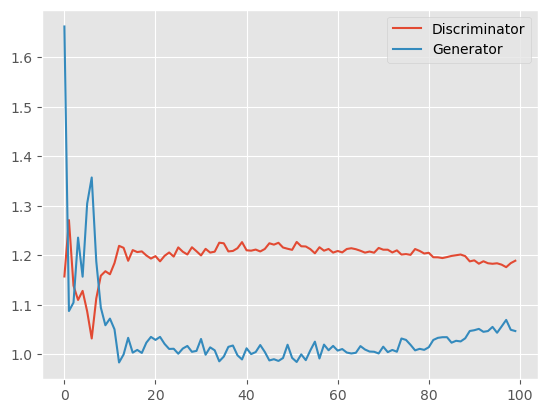

In [31]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

In [32]:
##
## Visualize image generation improvements
##

def show_generated_images(epoch, n_cols=8):
    # load saved images
    with open('fixed_samples.pkl', 'rb') as f:
        saved_data = pkl.load(f)  
    epoch_data = saved_data[epoch-1]
    # re-scale back to 0-1 
    epoch_data = (epoch_data + 1) / 2
    # re-shape to (batch_size, channel, height, width)
    batch_size, channel, height, width = len(epoch_data), 1, 28, 28
    image_batch = epoch_data.view(batch_size, channel, height, width)
    display_images(images=image_batch, n_cols=n_cols, figsize=(12, 4))

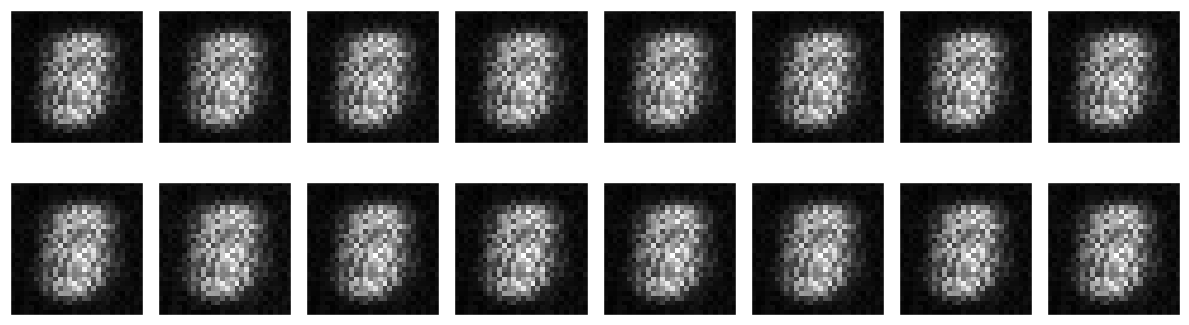

In [33]:
show_generated_images(epoch=1, n_cols=8)

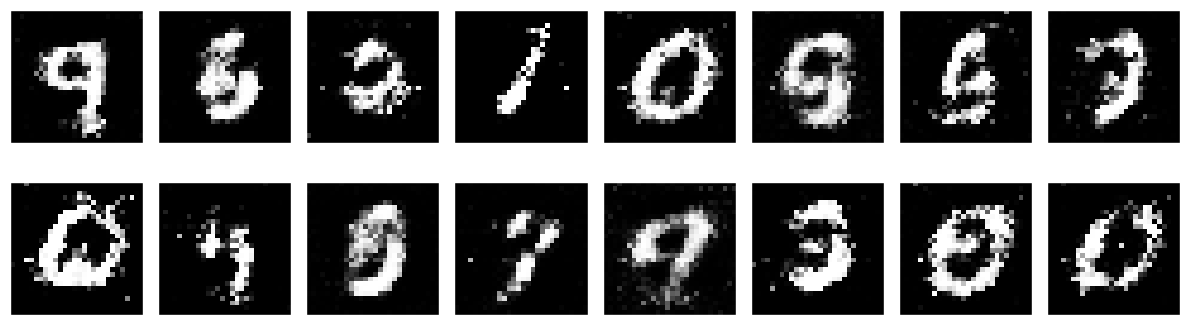

In [34]:
show_generated_images(epoch=10, n_cols=8)

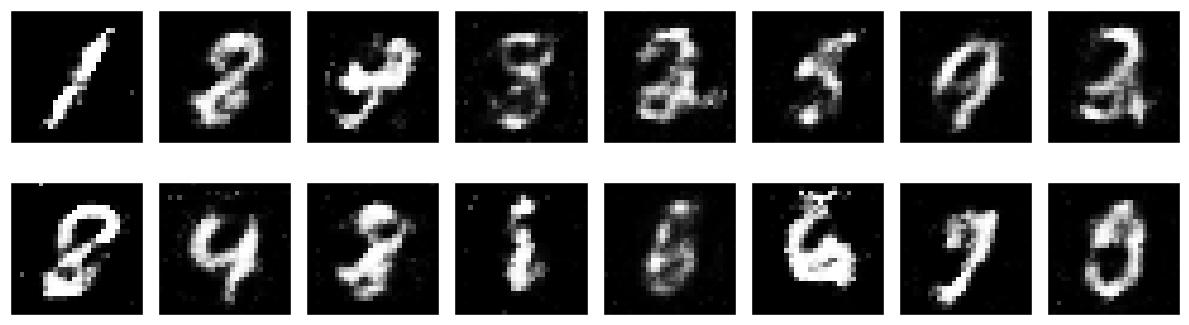

In [35]:
show_generated_images(epoch=50, n_cols=8)

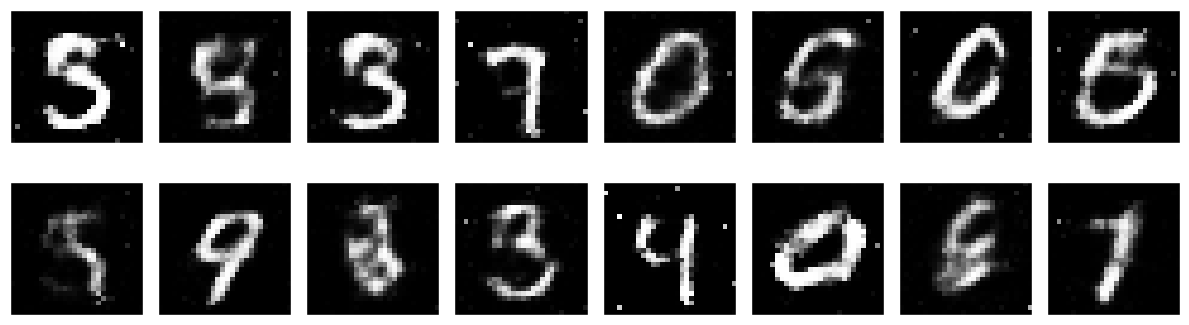

In [36]:
show_generated_images(epoch=100, n_cols=8)

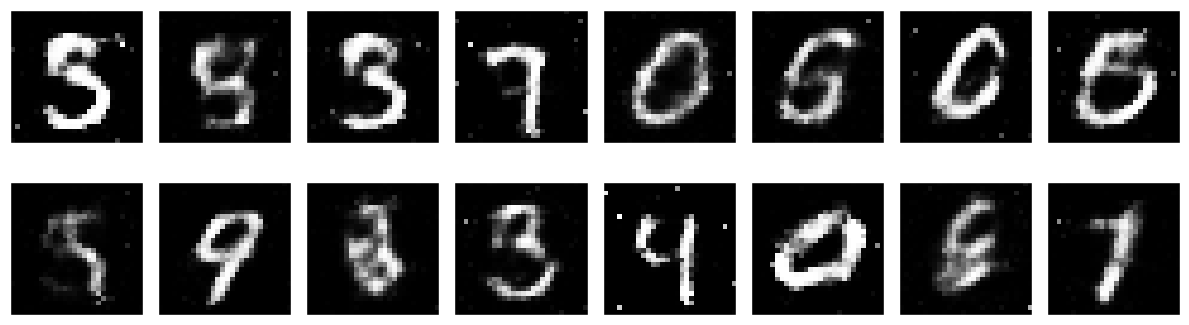

In [46]:
show_generated_images(epoch=100, n_cols=8)

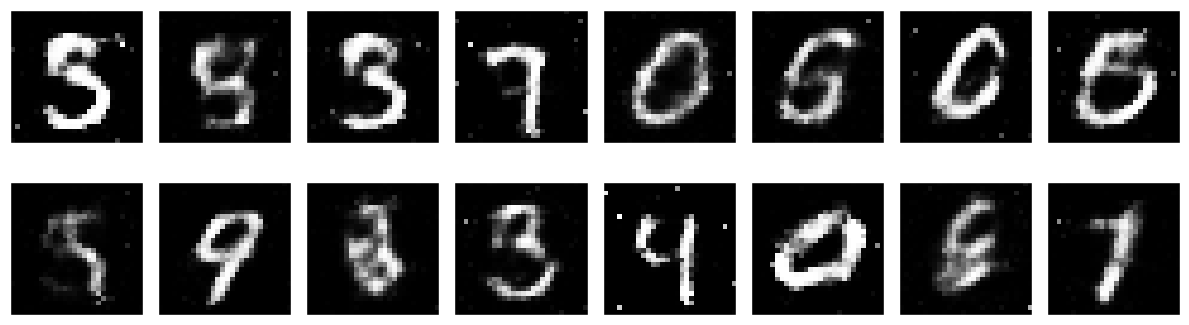

In [48]:
show_generated_images(epoch=100, n_cols=8)

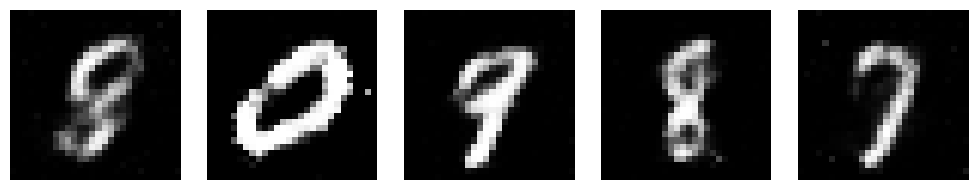

In [113]:
import numpy as np
import torch

g.to('cpu')
g.eval()

num_images = 5

z = np.random.uniform(-1, 1, size=(num_images, 100))
z = torch.from_numpy(z).float()

fake_images = g(z)
fake_images = fake_images.view(num_images, 1, 28, 28).detach()

def display_images(images, n_cols=1, figsize=(2, 2)):
    import matplotlib.pyplot as plt
    n_rows = (len(images) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i].squeeze(), cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

display_images(fake_images, n_cols=num_images, figsize=(2 * num_images, 2))
